In [1]:
import json
import pathlib
import pycolmap
import datetime
import random

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import RandomSampler, DataLoader, random_split

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import pyvista as pv

import neural_orientation_field.utils as utils
import neural_orientation_field.colmap.colmap_utils as colutils
from neural_orientation_field.nerf.dataset import NeRFImageDataset, NeRFPriorImageDataset, NeRFRayDataset
from neural_orientation_field.nerf.model import NeRfCoarseModel, NeRfFineModel
from neural_orientation_field.nerf.utils import pos_encode, static_volumetric_renderer, adaptive_volumetric_renderer, cam_ray_from_pose, nerf_image_render

In [2]:
# Seed rng for reproducability
np.random.seed(42)
torch.manual_seed(42)

# Load Dataset

In [3]:
# Input
IMAGE_PATH = "../../data/images/blender-hair-long/rendered/"
CAMERA_PATH = "../../data/camera/blender-hair-long/"
CHECKPOINT_PATH = "../../data/output/nerf/blender-hair-long/"

image_path = pathlib.Path(IMAGE_PATH).resolve()
camera_path = pathlib.Path(CAMERA_PATH).resolve()
checkpoint_path = pathlib.Path(CHECKPOINT_PATH).resolve()
if not checkpoint_path.exists():
    checkpoint_path.mkdir(parents=True, exist_ok=True)

frame_name_path = camera_path / "frame-names.txt"
cam_transform_path = camera_path / "camera-transforms.npy"
cam_param_path = camera_path / "camera-params.npy"

image_path, frame_name_path, cam_transform_path, cam_param_path, checkpoint_path

(PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/images/blender-hair-long/rendered'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/frame-names.txt'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/camera-transforms.npy'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/camera/blender-hair-long/camera-params.npy'),
 PosixPath('/Users/fangjun/Documents/stanford/cs229/final-project/data/output/nerf/blender-hair-long'))

In [4]:
# Blender Image Dataset
with open(frame_name_path, "r") as frame_path_file:
    frame_names = frame_path_file.read().split("\n")
    frame_paths = [image_path / frame_name for frame_name in frame_names]
with open(cam_transform_path, "rb") as cam_transform_file:
    cam_transforms = np.load(cam_transform_file)
with open(cam_param_path, "rb") as cam_param_file:
    cam_params = np.load(cam_param_file)
image_dataset = NeRFPriorImageDataset(frame_paths, cam_params, cam_transforms)
num_valid = 2
num_train = len(image_dataset) - num_valid
image_dataset_train, image_dataset_valid = random_split(image_dataset, [num_train, num_valid])
len(image_dataset_train), len(image_dataset_valid)

(126, 2)

In [5]:
with tqdm(total=len(image_dataset_train), desc="Processing Image") as progress:
    ray_dataset = NeRFRayDataset(image_dataset_train, progress)

Processing Image:   0%|          | 0/126 [00:00<?, ?it/s]

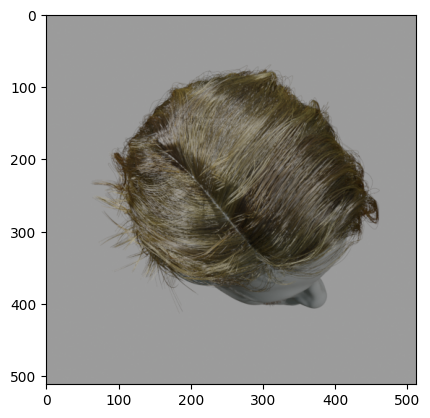

In [6]:
idx = 0
image, cam_transform, (h, w), (f, cx, cy) = image_dataset[idx]
plt.imshow(image)

In [7]:
# Visualize camera rays.
# origins = np.tile(cam_orig[np.newaxis, np.newaxis, :], (image.shape[0], image.shape[1], 1)).reshape(-1, 3)
# directions = cam_ray_world.reshape(-1, 3)
# colors = image.reshape(-1, 3)
# sample_idxs = np.arange(0, colors.shape[0])
# np.random.shuffle(sample_idxs)
# sample_idxs = sample_idxs[:1024]
# origins = origins[sample_idxs]
# directions = directions[sample_idxs]
# colors = colors[sample_idxs]

# origins = []
# directions = []
# colors = []
# for i in range(65535):
#     idx = random.randint(0, len(ray_dataset))
#     origin, direction, color = ray_dataset[idx]
#     origins.append(origin)
#     directions.append(direction)
#     colors.append(color)
# origins = np.array(origins)
# directions = np.array(directions)
# colors = np.array(colors)
# 
# # Normalize directions if necessary
# directions = directions / np.linalg.norm(directions, axis=1)[:, np.newaxis]
# 
# # Create the PyVista PolyData object
# vectors = pv.PolyData(origins)
# 
# # Add the directions and colors as point data
# vectors["directions"] = directions
# vectors["colors"] = colors
# 
# # Create the glyphs (arrows)
# arrows = vectors.glyph(orient="directions", scale=False, factor=1)
# 
# # Plot the arrows with colors
# plotter = pv.Plotter()
# plotter.add_mesh(arrows, scalars="colors", rgb=True)
# plotter.show()

# NeRF

In [8]:
# Use MPS device.
USE_DEVICE = "mps"

if USE_DEVICE == "mps" and torch.mps.is_available():
    device = torch.device("mps")
elif USE_DEVICE == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

# NeRF Training

In [9]:
# Near/far clipping distance.
nc = 1
fc = 8
# Positional encoding number.
coarse_pos_encode = 2
fine_pos_encode = 4
samples_per_ray = 4
max_subd_samples = 4
# Hyper parameters.
lr = 2e-4
num_epochs = 1
ray_batch_size = 8192
# Training settings.
size_train_ray = 0.25
valid_per_epoch = 2

In [ ]:
# Init model.
coarse_model = NeRfCoarseModel(num_encoding_functions=coarse_pos_encode)
coarse_model.to(device)
coarse_optimizer = torch.optim.Adam(coarse_model.parameters(), lr=lr)

fine_model = NeRfFineModel(num_encoding_functions=fine_pos_encode)
fine_model.to(device)
fine_optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

In [10]:
coarse_model.train()
fine_model.train()

train_sampler = RandomSampler(data_source=ray_dataset, num_samples=int(size_train_ray * len(ray_dataset)))
dataloader = DataLoader(
    ray_dataset,
    sampler=train_sampler,
    batch_size=ray_batch_size,
)

writer = SummaryWriter(flush_secs=1)
valid_images = np.array(
    [valid_image for valid_image, _, _, _ in image_dataset_valid]
)
writer.add_image("Valid Image Ground Truth",
                 valid_images, dataformats="NHWC")

best_loss = float("inf")
best_model_coarse = None
best_model_fine = None

for epoch in tqdm(range(num_epochs)):
    valid_every_n_batch = int(len(dataloader) / valid_per_epoch)
    # One iteration of the training.
    for batch_i, (cam_orig_batch, cam_ray_batch, color_batch) in enumerate(tqdm(dataloader)):
        cam_orig_batch = cam_orig_batch.type(torch.float32).to(device)
        cam_ray_batch = cam_ray_batch.type(torch.float32).to(device)
        color_batch = color_batch.type(torch.float32).to(device)
        coarse_color_pred, occupancy, sample_depth = static_volumetric_renderer(
            coarse_model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            nc,
            fc,
            num_sample=samples_per_ray,
            num_pos_encode=coarse_pos_encode,
            device=device
        )
        coarse_loss = torch.nn.functional.mse_loss(coarse_color_pred, color_batch)
        fine_color_pred, _, _ = adaptive_volumetric_renderer(
            fine_model,
            cam_orig_batch.reshape(-1, 3),
            cam_ray_batch.reshape(-1, 3),
            occupancy,
            sample_depth,
            max_subd_sample=max_subd_samples,
            num_pos_encode=fine_pos_encode,
            device=device
        )
        fine_loss = torch.nn.functional.mse_loss(fine_color_pred, color_batch)
        loss = coarse_loss + fine_loss
        loss.backward()
        coarse_optimizer.step()
        coarse_optimizer.zero_grad()
        fine_optimizer.step()
        fine_optimizer.zero_grad()
        writer.add_scalar("Coarse Loss Train", coarse_loss,
                          (epoch * len(dataloader) + batch_i) * ray_batch_size)
        writer.add_scalar("Fine Loss Train", fine_loss,
                          (epoch * len(dataloader) + batch_i) * ray_batch_size)

        if batch_i % valid_every_n_batch == 0:
            coarse_model.eval()
            fine_model.eval()

            coarse_preds = []
            fine_preds = []
            coarse_losses = []
            fine_losses = []
            for valid_image, cam_transform, (h, w), (f, cx, cy) in image_dataset_valid:
                cam_orig, cam_ray_world = cam_ray_from_pose(
                    cam_transform, h, w, f, cx, cy)
                coarse_pred, fine_pred = nerf_image_render(
                    coarse_model,
                    fine_model,
                    cam_orig,
                    cam_ray_world,
                    ray_batch_size,
                    nc,
                    fc,
                    samples_per_ray,
                    max_subd_samples,
                    coarse_pos_encode,
                    fine_pos_encode,
                    device
                )
                coarse_preds.append(coarse_pred)
                fine_preds.append(fine_pred)
                valid_image = torch.tensor(valid_image)
                coarse_loss = torch.nn.functional.mse_loss(
                    coarse_pred, valid_image)
                fine_loss = torch.nn.functional.mse_loss(
                    fine_pred, valid_image)
                coarse_losses.append(coarse_loss)
                fine_losses.append(fine_loss)

            coarse_preds = np.array(coarse_preds)
            fine_preds = np.array(fine_preds)
            coarse_loss_valid = np.array(coarse_losses).mean()
            fine_loss_valid = np.array(fine_losses).mean()
            loss_valid = coarse_loss_valid + fine_loss_valid
            if loss_valid < best_loss:
                best_model_coarse = coarse_model.state_dict()
                best_model_fine = fine_model.state_dict()
                best_loss = loss_valid
            writer.add_scalar("Coarse Loss Valid", coarse_loss_valid,
                              (epoch * len(dataloader) + batch_i) * ray_batch_size)
            writer.add_scalar("Fine Loss Valid", fine_loss_valid,
                              (epoch * len(dataloader) + batch_i) * ray_batch_size)
            writer.add_image("Rendered Validation Image Coarse", coarse_preds, (epoch *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="NHWC")
            writer.add_image("Rendered Validation Image Fine", fine_preds, (epoch *
                             len(dataloader) + batch_i) * ray_batch_size, dataformats="NHWC")
            coarse_model.train()
            fine_model.train()

    torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_epoch_{epoch}.pth")
    torch.save(fine_model.state_dict(), checkpoint_path / f"fine_epoch_{epoch}.pth")
writer.close()

if best_model_coarse:
    coarse_model.load_state_dict(best_model_coarse)
if best_model_fine:
    fine_model.load_state_dict(best_model_fine)

torch.save(coarse_model.state_dict(), checkpoint_path / f"coarse_final.pth")
torch.save(fine_model.state_dict(), checkpoint_path / f"fine_final.pth")

model_params = {
    "coarse_pos_encode": coarse_pos_encode,
    "fine_pos_encode": fine_pos_encode,
    "nc": nc,
    "fc": fc,
    "samples_per_ray": samples_per_ray,
    "max_subd_samples": max_subd_samples,
}
torch.save(model_params, checkpoint_path / f"model_params.pth")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1008 [00:00<?, ?it/s]